<a href="https://colab.research.google.com/github/steed360/Data-Wrangling-And-Visualisation-Toolkits/blob/main/8_Facetted_Bar_Chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Useful for multiple chartS: patchworklib

# https://github.com/has2k1/plotnine/issues/46

Recreate this chart in Plotnine

https://github.com/adamribaudo/storytelling-with-data-ggplot/blob/master/FIG0902.R

In [7]:
#pip install plotnine

## Import libraries
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import transforms
import pandas as pd
from pandas import CategoricalDtype


#import seaborn as sns
#from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line
from plotnine import ggplot  # https://plotnine.readthedocs.io/en/stable/
import pandas as pd
import plotnine
%matplotlib inline

from  mizani import formatters # for better axis labelling
from matplotlib.patches import Rectangle


In [2]:
# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
BLUE5, BLUE6 = '#92CDDD', '#2E869D'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1, ORANGE2, ORANGE3 = '#F79747', '#FAC090', '#F36721'

In [3]:
def color_title(labels, colors, textprops = {'size':'large'}, ax = None, y = 1,
               precision = 10**-2):
     
    "Creates a centered title with multiple colors. Don't change axes limits afterwards."
        
    if ax == None:
        ax = plt.gca()
        
    plt.gcf().canvas.draw()
    transform = ax.transAxes # use axes coords
    
    # initial params
    xT = 0 # where the text ends in x-axis coords
    shift = 0 # where the text starts
    
    # for text objects
    text = dict()

    while (np.abs(shift - (1-xT)) > precision) and (shift <= xT) :         
        x_pos = shift 
        
        for label, col in zip(labels, colors):
            try:
                text[label].remove()
            except KeyError:
                pass
            
            text[label] = ax.text(x_pos, y, label, 
                        transform = transform, 
                        ha = 'left',
                        color = col,
                        **textprops)
            
            x_pos = text[label].get_window_extent()\
                   .transformed(transform.inverted()).x1
            
        xT = x_pos # where all text ends
        
        shift += precision/2 # increase for next iteration
      
        if x_pos > 1: # guardrail 
            break

In [4]:
# empathy87 on github

def rainbow_text(x, y, text, colors, spacing=20, ax=None, **kw):
    colors = list(reversed(colors))
    t = ax.transData
    canvas = ax.figure.canvas

    for i, line in enumerate(reversed(text.split('\n'))):
        strings = line.split('||')
        for s, c in zip(strings, colors[i]):
            text = ax.text(x, y, s, color=c, transform=t, **kw)
            text.draw(canvas.get_renderer())
            ex = text.get_window_extent()
            t = transforms.offset_copy(text._transform, x=ex.width, 
                                       units='dots')

        t = transforms.offset_copy(ax.transData, x=0, y=(i + 1) * spacing, 
                                   units='dots')
        

In [8]:
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

#### Read in and process the data

In [56]:

#df = pd.read_csv ( 'Data\FIG0902.csv')

fileURL = 'https://raw.githubusercontent.com/steed360/Data-Wrangling-And-Visualisation-Toolkits/main/Data%20Visualisation/Plotnine/Data/data/FIG0315-16.csv' 

df = pd.read_csv ( fileURL)
df.head()



,Category,Our business,Competitor A,Competitor B,Competitor C,Competitor D,Competitor E,Rank
0,Price,1.81,1.59,0.26,1.02,1.60,0.76,1 of 6
1,Convenience,1.70,2.18,0.72,0.82,1.64,0.05,2 of 6
2,Relationship,0.70,1.98,0.62,0.67,1.10,1.20,4 of 6
3,Service,0.31,0.50,1.23,0.69,1.11,2.06,6 of 6
4,Selection,0.26,0.27,0.87,0.43,1.60,2.40,6 of 6


In [140]:
# Unpivot the table 
df_long = pd.melt (df.reset_index(), 
    id_vars = 'Category', 
    value_vars = ['Our business', 'Competitor A', 'Competitor B', 'Competitor B','Competitor C', 'Competitor D',	'Competitor E'  ] ,
    value_name='Result', var_name='Business' )


df_long['ranking_desc'] = df_long.groupby ( 'Category')['Result']  .rank(method='dense', ascending=False).astype(int).astype(str) + ' of 6'

df_long.loc [~ (df_long['Business'] =='Our business') ,'ranking_desc'  ] = ''


df_long.head(7)

,Category,Business,Result,ranking_desc
0,Price,Our business,1.81,1 of 6
1,Convenience,Our business,1.70,2 of 6
2,Relationship,Our business,0.70,4 of 6
3,Service,Our business,0.31,6 of 6
4,Selection,Our business,0.26,6 of 6
5,Price,Competitor A,1.59,
6,Convenience,Competitor A,2.18,


Sort the businesses name : Our Business at the bottom then A, then B going up

In [144]:
lstTemp = list( reversed ( list ( df_long['Business'].unique() )))
lstTemp

['Competitor E',
 'Competitor D',
 'Competitor C',
 'Competitor B',
 'Competitor A',
 'Our business']

In [145]:
from pandas import CategoricalDtype
df_long['Business_Cat'] = df_long.Business.astype (CategoricalDtype(ordered=True))
df_long['Business_Cat'] = df_long['Business_Cat'].cat.reorder_categories(  lstTemp )
df_long['Business_Cat'] [0:3]

0    Our business
1    Our business
2    Our business
Name: Business_Cat, dtype: category
Categories (6, object): ['Competitor E' < 'Competitor D' < 'Competitor C' < 'Competitor B' <
                         'Competitor A' < 'Our business']

Sort the Categories 

In [146]:
lstTemp2 = list ( df_long.Category.unique() )
df_long['Category_Cat'] = df_long.Category.astype (CategoricalDtype(ordered=True))
df_long['Category_Cat'] = df_long['Category_Cat'].cat.reorder_categories(  lstTemp2 )
df_long['Category_Cat'] [0:3]

0           Price
1     Convenience
2    Relationship
Name: Category_Cat, dtype: category
Categories (5, object): ['Price' < 'Convenience' < 'Relationship' < 'Service' < 'Selection']

In [98]:
def SWD_theme ():

    # Basic information from the 
    
    font = "Arial"
    t=theme_minimal(base_size = 10, base_family = font ) 

    t2 = theme(
      panel_grid_major = element_blank(),
      panel_grid_minor = element_blank(),

      axis_line = element_line(size = .1, color = GRAY9),
      axis_text = element_text(color = GRAY3, size = 12),

      #axis.ticks.x = element_line(size = 0.5, color = GRAY9),
      #axis.ticks.y = element_line(size = 0.5, color = GRAY9),
        
      axis_title = element_text(color = GRAY5),

      #axis_title_y = element_text(hjust = 1, margin = margin(0, 6, 0, 15, "pt")),
      #axis_title_x = element_text(hjust = 0, margin = margin(6, 0, 15, 0, "pt")),
      #plot_subtitle = element_text(color = GRAY4, size= 8),

      plot_title = element_text(color = GRAY4, size= 12 ),
        
      # I don't think this line is implemented in plotnine
      #plot_title_position = "plot", # This aligns the plot title to the very left edge
        
      #plot_caption = element_text(hjust = 0, color = GRAY6),
      #plot_caption_position = "plot",

      #plot_margin = margin(.5,.5,.5,.5,"cm"),
      plot_margin = (0.1 ),  
        
      strip_text = element_text(color = GRAY7)) 
    
    return t+ t2


In [ ]:
# This list will allow us to order the y axis on the final chart.
#l = list ( reversed (df.item.value_counts ( ).index.tolist() ) )
#l = list ( df.item.value_counts ( ).index.tolist() ) 
#l

['Survey item A', 'Survey item B', 'Survey item C', 'Survey item D']

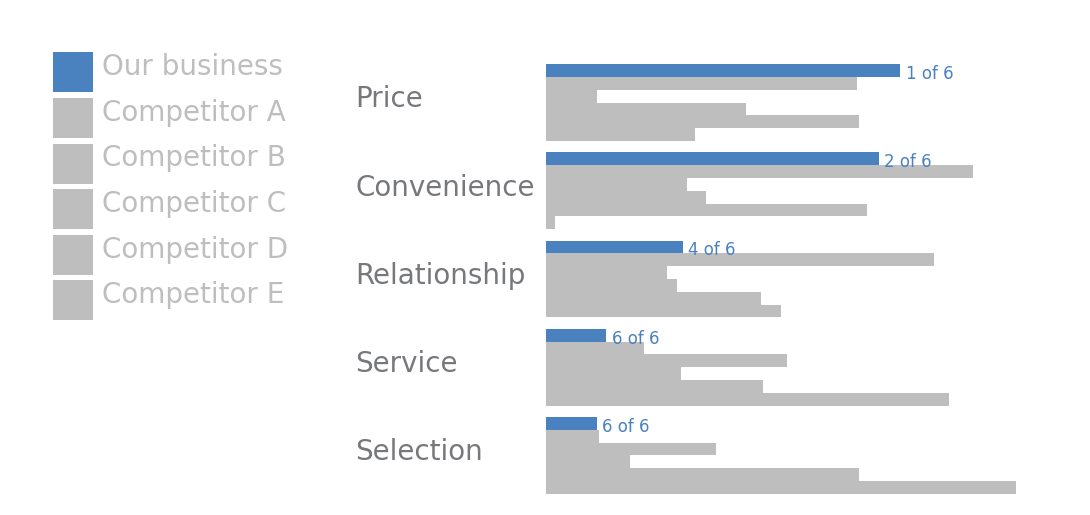

In [210]:
from plotnine.themes.themeable import axis_ticks
t = theme(         
          # Overrides
          #axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 15, color = GRAY9 ), #, y = 0.52), 
          axis_title_y = element_blank(), 

          # Turn off tick labels
          axis_ticks_length=0, 
          
          #text=element_text(color="red"),
          axis_text=element_text(color=GRAY9),

          axis_text_x=element_blank(),
          axis_text_y=element_blank(),

          panel_grid_major_y=element_blank() ,

          # X axis title
          #axis_title_x=element_text(angle = 0, va = 'top',ha='left' , size = 12, color = GRAY9 , x=0.1) #, y = 0.52)         

          axis_title_x =  element_blank() ,

          legend_position = (0, 0.6)  ,

          legend_title = element_blank(),
          legend_text =  element_text( va = 'bottom', ha = 'left', size = 10, color = GRAY9 ),


          panel_background = element_blank(),
          axis_ticks = element_blank(),
          strip_background = element_blank(),

          strip_text_y = element_blank(),  # the facet panel title.

          # Make some space to the left for the facet labels, make some space above for the title.
          subplots_adjust={'left': 0.35, 'top':0.8  },   # margin to left of plot

          # No grid lines needed here

          axis_line_x  = element_blank(),
          axis_line_y  = element_blank(),             
)

fig = ( ggplot(data=df_long ) +

  geom_col( mapping=aes ( x='Business_Cat', y='Result', fill='Business_Cat' ), width=1   )   +
     facet_grid ( 'Category_Cat~.' ) +
     scale_fill_manual(values = [GRAY9,GRAY9,GRAY9,GRAY9,GRAY9, BLUE2],  
                       labels =["Competitor E","Competitor D","Competitor C","Competitor B","Competitor A", 'Our business'] , 
                       guide = guide_legend(reverse = True ) )      +
     coord_flip()  + 
     geom_text(aes(x = 'Business_Cat', y = 'Result', label = 'ranking_desc' ),nudge_y = .15,nudge_x = -.2,color = BLUE2,size =6 ) + 
     SWD_theme() + t
      
).draw(show=False, return_ggplot=False)

# Add in the facet labels that plotnine won't do yet
for index,cat in  enumerate ( df_long['Category_Cat'].cat.categories ):
    ax = fig.axes[index]
    ax.text(-0.30, .45, cat, transform=ax.transAxes, color=GRAY5, fontsize=10)


# Blank axis for title, notes (and to fill the screen.)


#ax0.axis('Off') # don't draw anything.

#Title
#ax0.text( -0.15 , 0.9,
#         'We score well on Price and Convenience' + ' '*20,
#         fontsize=26,
#         color='white',
        # put a rectangular box around the text to set a background color
#         bbox={'facecolor': GRAY7, 'pad': 12, 'edgecolor': "None"})


fig.dpi = 200
width_in = 5
fig.set_size_inches(width_in , width_in/1.62) 

